# Sparkify Project

For many businesses it is crucial crucial to predict if a user it is likely to quit using this service (called "churn"). The success of a subscription based service e. g. music streaming is related to the total number of user of the service. As more users use the service as more revenues can be generated by subscription fees or advertising. If you can predict churn you can target the user with specific measures to keep the user using the service.
This project uses log data of a fictional music streaming service called Sparkify. The software Spark is used to process the data and to demonstrate how to predict churn. The Project contains the following steps:
Exploratory Data Analysis
Extract and engineering of features for the model
Building and of a machine learning model
Evaluation and refinement of the model

The project is conducted by using PySpark and deployed on the cloud platform IBM Watson.

In [1]:
# import libaries
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE

from pyspark.ml.linalg import DenseVector, SparseVector

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190320082150-0000
KERNEL_ID = ed592564-3d02-456a-bb7c-ba0f1c84b623


In [2]:
# create a Spark session
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-0cfd8af9-11d0-494f-abf4-1f5d93ad895f',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'QMvBkx5HgGBf5l3YLVSjrhyi9ttjyTH_o1VMngV4VLMM'
}

configuration_name = 'os_cfaac7c0ade144ff973ceaf9bb435748_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-tuxfhoxxansigv'))
df_data_1.take(5)


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Load and Clean Dataset
Clean the dataset, checking for invalid or missing data. For removing records without userids. 

In [3]:
def loader(path): 
    ''' load dataset and remove records without userids or sessionids. 
    ''' 
    df = spark.read.json(path)
    return df

def nan_count(df):
    '''Counting the NaN Values for each columns 
    Input raw data frame: df 
    Credits: https://stackoverflow.com/questions/44627386/
    how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe'''
    nan_counter = (df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas())
    return nan_counter

def cleaner(df): 
    ''' remove records without userids or sessionids,  get intrepretable timestamp and registration in satetime format
    Input raw data frame: df 
    Output: cleaned dataframe, with aaditional timestamp and registration columns
    '''   
    df_size_raw = df.count()
    df = df.filter(df.userId!="")
   
    df_size_clean = df.count()
    df_droped_size = (df_size_raw - df_size_clean)
    print ("Size of raw dataset: {}, size of cleaned dataset: {}, records dropped: {}".format(df_size_raw, df_size_clean, df_droped_size))
    clean_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
    df = df.withColumn("timestamp", clean_ts(df.ts))
    df = df.withColumn("registration_ts", clean_ts(df.registration))
    
    print (df.agg(f.min('timestamp'), f.max('timestamp')).show())
    print (df.agg(f.min('registration_ts'), f.max('registration_ts')).show())
    
    return df



In [8]:
# load the data
df = df_data_1
df = cleaner(df)

df.head()

Size of raw dataset: 543705, size of cleaned dataset: 528005, records dropped: 15700
+--------------+--------------+
|min(timestamp)|max(timestamp)|
+--------------+--------------+
|    2018-10-01|    2018-12-01|
+--------------+--------------+

None
+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
|          2017-11-05|          2018-11-24|
+--------------------+--------------------+

None


Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', timestamp='2018-10-01', registration_ts='2018-07-20')

In [9]:
# print shema of data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- registration_ts: string (nullable = true)



The data contains usage information relevant for this analysis ( e. g. a unique sessionID, ts (timestamp) , song…) and information of the user (e.g. a userID, a registration timestamp, level, status of the member, gender). "Page" describes the specific event occur during the usage of the sevice (For example  "NextSong", "ThumbsUp").

In [10]:
# count nan
nan_count(df)


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,timestamp,registration_ts
0,95128,0,0,0,0,0,95128,0,0,0,0,0,0,95128,0,0,0,0,0,0


# Exploratory Data Analysis

### Define Churn


The event "Cancellation Confirmation" marks the last event a user had in the during  the useage the service. For this project "Cancellation Confirmation" is used to define churn.

In [21]:
churn =  df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()

churn_users = [(row['userId']) for row in churn.collect()]

df = df.withColumn('churn', df.userId.isin(churn_users))

In [22]:
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', timestamp='2018-10-01', registration_ts='2018-07-20', churn=True)

In [23]:
df.groupby('churn','userId').count().sort('count', ascending=False).show()


+-----+------+-----+
|churn|userId|count|
+-----+------+-----+
|false|    92| 9767|
| true|   140| 7448|
|false|300049| 7309|
|false|   101| 6842|
|false|300035| 6810|
|false|   195| 6184|
|false|   230| 6019|
|false|   163| 5965|
|false|   250| 5678|
| true|    18| 5511|
|false|   276| 5346|
|false|300017| 5266|
|false|    87| 5243|
| true|   293| 5125|
|false|300021| 5076|
|false|    42| 4952|
|false|300011| 4816|
|false|    30| 4737|
|false|    12| 4232|
|false|300031| 4194|
+-----+------+-----+
only showing top 20 rows



In [24]:
# count churn user in dataset
df.groupby(col('churn')).agg(f.countDistinct(col('userId')).alias('user_count')).toPandas() 

,churn,user_count
0,True,99
1,False,349


## Data Exploration
Based on the definition of churn, a analysis of the usage of this service of churned and not churned users can be made.

In [25]:
# helper function for Plotting

# plot histogram
def plot_hist(i, col):
    '''
    plot histograms for values
    Input: i: variable histograms are printed for 
           col: col histograms are printed for 
    
    '''
    g = sns.FacetGrid(df_explore.toPandas(), col=col)
    g = g.map(plt.hist, i, bins=40)

# calculate and plot average values 

def plot_avg(j,n):
    '''
    calculate and plot average values for churned and not churned values and plot barchart
    Input: i: variable average calculated for
           j: naming for barchart
    '''
    average_value = df_explore.groupBy('churn').agg(f.avg(j).alias(n)).toPandas()
    sns.barplot(x="churn", y=n, data=average_value)
    print(average_value.head())

### How many sessions had the users?
As we  see below, there are differences in the distribution of numbers of sessions users had. User who didn't churned tend to have a much higher number of sessions. This behavoir could be expected, because users who churn would not accumulate any sessions anymore.    


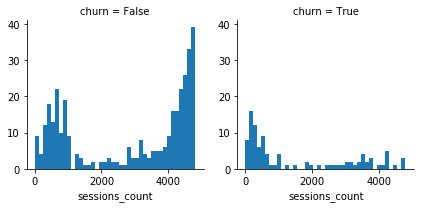

In [26]:
#how many sessions had the users?
df_explore = df.groupBy('userId', 'churn').agg(f.max('sessionId').alias('sessions_count'))
plot_hist("sessions_count", "churn")

   churn  average_number_of_sessions
0   True                 1508.171717
1  False                 2863.934097


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


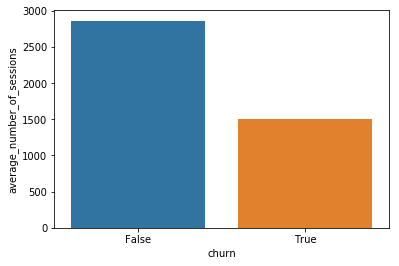

In [27]:
#calculate the average number_of_sessions of a user
plot_avg('sessions_count','average_number_of_sessions')

### How many distinct sessions the user have in the dataset ?

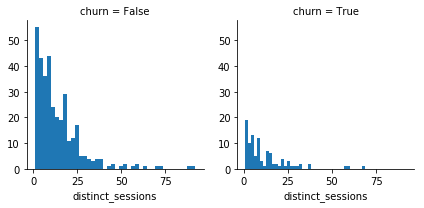

In [28]:
#how many sessions had the users?
sessions = df.groupBy('userId').agg(f.countDistinct('sessionId').alias('distinct_sessions'))
df_explore = df_explore.join(sessions, "userId")
plot_hist("distinct_sessions", "churn")


   churn  average_distinct_sessions
0   True                  12.090909
1  False                  13.991404


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


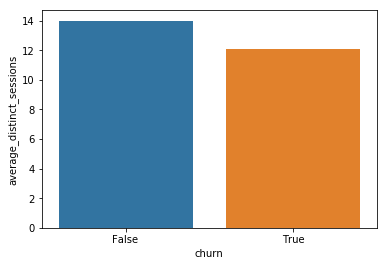

In [29]:
plot_avg('distinct_sessions','average_distinct_sessions')

### How many days the user were active in Sparkify? 

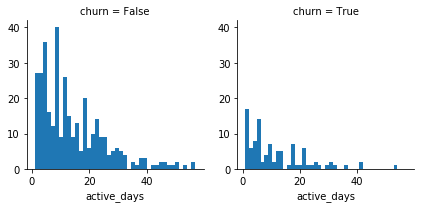

In [30]:
active_days = df.groupby('userId').agg(f.countDistinct("timestamp").alias('active_days')) 
df_explore = df_explore.join(active_days, "userId")

plot_hist("active_days", "churn")




   churn  average_active_days
0   True            11.636364
1  False            14.163324


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


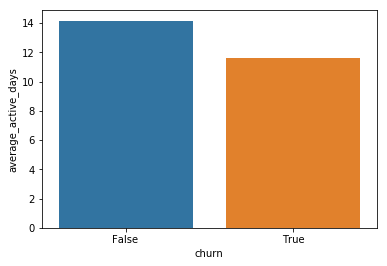

In [31]:
plot_avg('active_days','average_active_days')

### How old are the accounts?

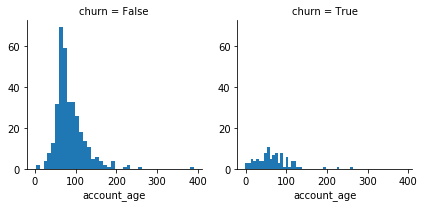

In [32]:
# days in system
age = df.groupby('userId').agg(((max(col('ts')) - min(col('registration')))/86400000).alias("account_age"))
df_explore = df_explore.join(age, "userId")

plot_hist("account_age", "churn")



   churn  average_account_age
0   True            67.968020
1  False            87.048714


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


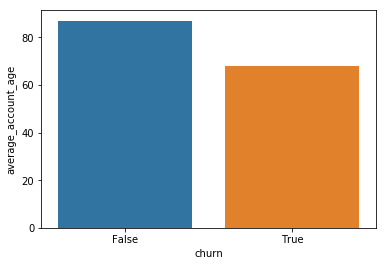

In [33]:
#calculate the average account age of a user
plot_avg('account_age','average_account_age')

### What actions the user perfomed on Sparkify?

In [34]:
pages = df.select('page').distinct().sort('page')
pages = [r.page for r in pages.collect()]
pages_count = df.groupby('userId').pivot('page', pages).count().fillna(0)
pages_count.head()

Row(userId='200002', About=1, Add Friend=2, Add to Playlist=6, Cancel=1, Cancellation Confirmation=1, Downgrade=3, Error=0, Help=1, Home=23, Logout=11, NextSong=310, Roll Advert=11, Save Settings=0, Settings=2, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=5, Thumbs Up=15, Upgrade=2)

In [35]:
df_explore = df_explore.join(pages_count, "userId")
df_explore.toPandas().head() 

,userId,churn,sessions_count,distinct_sessions,active_days,account_age,About,Add Friend,Add to Playlist,Cancel,...,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,True,166,2,2,14.328449,0,3,1,1,...,1,96,22,0,0,0,0,3,4,2
1,200002,True,239,5,6,53.323148,1,2,6,1,...,11,310,11,0,2,0,1,5,15,2
2,296,True,1228,5,5,26.638264,0,2,3,1,...,3,112,9,0,1,0,1,0,8,1
3,125,False,2220,3,3,105.422118,0,3,2,0,...,0,62,6,0,3,0,0,1,3,0
4,124,True,3475,17,22,112.553796,3,26,45,1,...,17,1826,1,3,15,0,0,15,102,0


### How many songs the users heard?

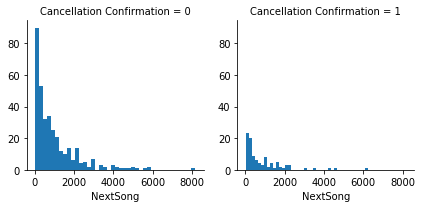

In [36]:
plot_hist("NextSong", "Cancellation Confirmation")

   churn  average_songs
0   True     852.111111
1  False     998.618911


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


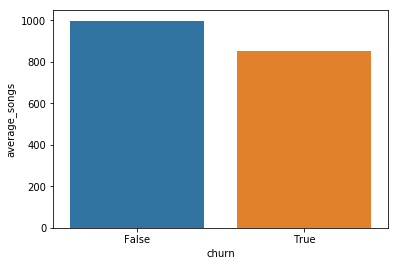

In [37]:
plot_avg('NextSong','average_songs')

### How many songs the users heard per session?

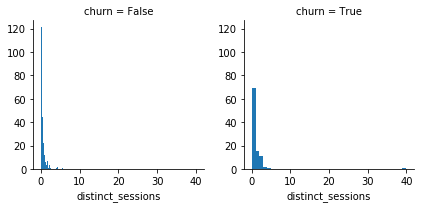

In [38]:
# how many songs the users heard per session
df_explore = df_explore.withColumn('distinct_sessions',  df_explore['NextSong']/df_explore['sessions_count'])

plot_hist("distinct_sessions", "churn")


   churn  average_songs_session
0   True               1.337715
1  False               0.542632


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


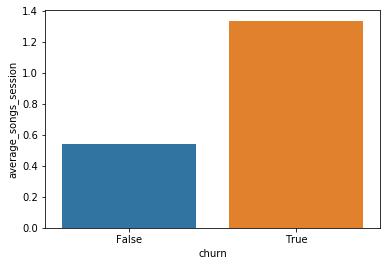

In [39]:
plot_avg('distinct_sessions','average_songs_session')

### How many thumps up per song?

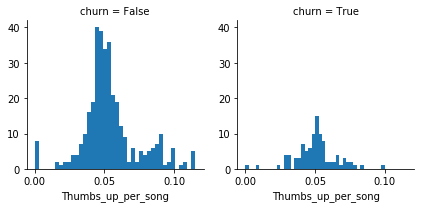

In [40]:
# how many thumbs up per user
df_explore = df_explore.withColumn('Thumbs_up_per_song',  df_explore['Thumbs Up']/df_explore['NextSong'])

plot_hist("Thumbs_up_per_song", "churn")


   churn  average_Thumbs_up_per_song
0   True                    0.050555
1  False                    0.054290


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


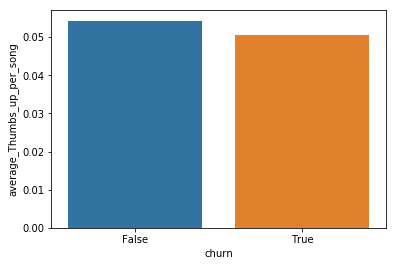

In [41]:
plot_avg('Thumbs_up_per_song','average_Thumbs_up_per_song')

### How many thumps down per songs

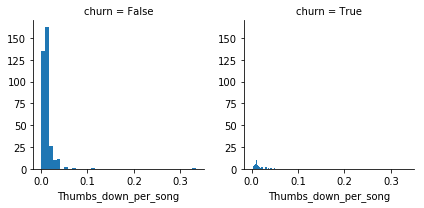

In [42]:
# how many thumbs down per song
df_explore = df_explore.withColumn('Thumbs_down_per_song',  df_explore['Thumbs Down']/df_explore['NextSong'])

plot_hist("Thumbs_down_per_song", "churn")



   churn  average_Thumbs_down_per_song
0   True                      0.013892
1  False                      0.012048


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


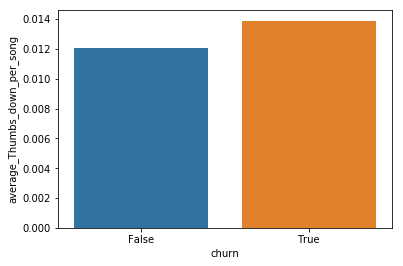

In [43]:
plot_avg('Thumbs_down_per_song','average_Thumbs_down_per_song')

### How many friends the user added?

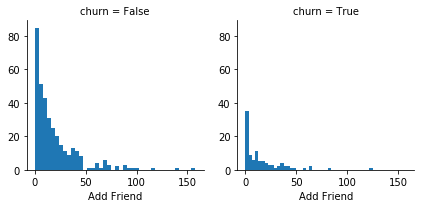

In [44]:
plot_hist("Add Friend", "churn")


   churn  average_added_friends
0   True              15.525253
1  False              18.767908


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


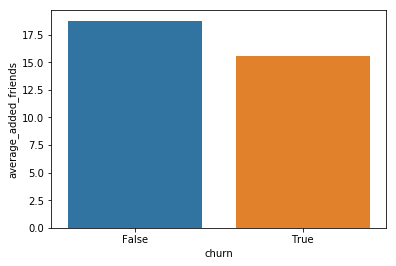

In [45]:
plot_avg('Add Friend','average_added_friends')

In [46]:
df_explore.toPandas().head() 

,userId,churn,sessions_count,distinct_sessions,active_days,account_age,About,Add Friend,Add to Playlist,Cancel,...,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,Thumbs_up_per_song,Thumbs_down_per_song
0,100010,True,166,0.578313,2,14.328449,0,3,1,1,...,22,0,0,0,0,3,4,2,0.041667,0.031250
1,200002,True,239,1.297071,6,53.323148,1,2,6,1,...,11,0,2,0,1,5,15,2,0.048387,0.016129
2,296,True,1228,0.091205,5,26.638264,0,2,3,1,...,9,0,1,0,1,0,8,1,0.071429,0.000000
3,125,False,2220,0.027928,3,105.422118,0,3,2,0,...,6,0,3,0,0,1,3,0,0.048387,0.016129
4,124,True,3475,0.525468,22,112.553796,3,26,45,1,...,1,3,15,0,0,15,102,0,0.055860,0.008215


# Feature Engineering

To build and train a model following features are extracted and calculated from the dataset: 

Events per user: For every specific event the total number of events per user is calulated.

Number of sessions: The number of distinct sessions a user had in the dataset

Songs per session: Number of songs per distinct session in the dataset

Active days: The number of days a user was active with the service 

Account age: Age of the a user account in days from  registration

Thumbs up per song: Number of thumbs up per number of songs a user heard

Thumbs down per song: Number of thumbs down per number of songs a user heard

To lable the data into churn and not churn the event "Cancellation Confirmation" is used as discussed before.

In [11]:
#load and clean data
df_load = df_data_1
df_load = cleaner(df_load)


Size of raw dataset: 543705, size of cleaned dataset: 528005, records dropped: 15700
+--------------+--------------+
|min(timestamp)|max(timestamp)|
+--------------+--------------+
|    2018-10-01|    2018-12-01|
+--------------+--------------+

None
+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
|          2017-11-05|          2018-11-24|
+--------------------+--------------------+

None


In [12]:
#counting nan
nan_count(df_load)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,timestamp,registration_ts
0,95128,0,0,0,0,0,95128,0,0,0,0,0,0,95128,0,0,0,0,0,0


In [13]:
#function for engeering the features
def eng_features(df_load):

    pages = df_load.select('page').distinct().sort('page')
    pages = [r.page for r in pages.collect()]

    # caculate number events per user 
    df_features = df_load.groupby('userId').pivot('page', pages).count().fillna(0)
    #  calculate number of sessions per user
    df_features = df_features.join(df_load.groupBy('userId').agg(f.max('sessionId').alias('sessions_count')), "userId")
    #  calculate number of songs per sessions per user
    df_features = df_features.withColumn('distinct_sessions',  df_features['NextSong']/df_features['sessions_count'])
    # calculate number of active days per user
    df_features = df_features.join(df_load.groupby('userId').agg(f.countDistinct("timestamp").alias('active_days')), "userId")
    # calculate number of acount age per user
    df_features = df_features.join(df_load.groupby('userId').\
                               agg(((max(col('ts')) - min(col('registration')))/86400000).alias("account_age")), "userId")
    # calculate thumbs up per song
    df_features = df_features.withColumn('Thumbs_up_per_song',  df_features['Thumbs Up']/df_features['NextSong'])
    # how many thumbs down per song
    df_features = df_features.withColumn('Thumbs_down_per_song',  df_features['Thumbs Down']/df_features['NextSong'])

    # rename cancellation confirmation to label
    df_features = df_features.withColumnRenamed('Cancellation Confirmation', 'label')
    return df_features




In [14]:
# engineer festures for model
df_features = eng_features(df_load)
df_features.head()

Row(userId='100010', About=0, Add Friend=3, Add to Playlist=1, Cancel=1, label=1, Downgrade=0, Error=0, Help=0, Home=3, Logout=1, NextSong=96, Roll Advert=22, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=3, Thumbs Up=4, Upgrade=2, sessions_count=166, distinct_sessions=0.5783132530120482, active_days=2, account_age=14.328449074074074, Thumbs_up_per_song=0.041666666666666664, Thumbs_down_per_song=0.03125)

# Modeling

In [15]:
# defining of helper funnctions for preparation of data, for metrics and training and testing the model
def prepare_data(df_features):
    ''' prepare data for model and split into test and train data
    Input:  df_feature: dataframe with features 
    Output: df_train: data for training 
            df_test: data for testing
    '''
    # exclude features not needed
    non_features = {'userId','label','Cancel'}
    feature_cols = sorted(list(set(df_features.columns)-non_features))  
    # assemble and scale feature vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_vec')
    scaler = StandardScaler(inputCol="features_vec", outputCol="features")
    pipeline = Pipeline(stages=[assembler, scaler])
    df_model = pipeline.fit(df_features).transform(df_features)
    df_model = df_model.select('features','label')
    # split into testing and traing data
    df_train, df_test = df_model.randomSplit([0.8, 0.2], seed=42)
    return  df_train, df_test, feature_cols 

def metrics(results):
    '''Description: prints accuracy and f1-score of training data
    Input: 
        results: predictions and labels of test data
    '''
    accuracy = MCE(metricName='accuracy').evaluate(results.select(col('label'), col('prediction')))
    f1_score = MCE(metricName='f1').evaluate(results.select(col('label'), col('prediction')))
    print ("the accuracy on the test set is: {}".format(accuracy))
    print ("the F1-score on the test set is: {}".format(f1_score))

def clf_fit_transform(clf):
    '''Description: fits classifier with training data and make predictictions 
    Input:
        clf: classifier 
    Output:    
        results: predictions based on test data
    '''
    model = clf.fit(df_train)
    print(model)
    results = model.transform(df_test)
    metrics(results)



For the selection of a model the data was split in 80% training data and 20% testing data.

In [17]:
# split data in test and training data, getting list with names of features
df_train, df_test, feature_cols  = prepare_data(df_features)

 Different classification models ( Logistic Regression, Decision Tree, Random Forest and GBT) were tested.

In [43]:
#Testing different classifiers for model selection
for clf in [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), GBTClassifier()]:
    clf_fit_transform(clf)

LogisticRegression_408a9fae105527070aa8
the accuracy on the test set is: 0.8023255813953488
the F1-score on the test set is: 0.7954735577288697
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_401dad34b96a9ce80660) of depth 5 with 39 nodes
the accuracy on the test set is: 0.7209302325581395
the F1-score on the test set is: 0.7306553911205074
RandomForestClassificationModel (uid=RandomForestClassifier_4024b7eab20986b7349d) with 20 trees
the accuracy on the test set is: 0.8372093023255814
the F1-score on the test set is: 0.8114784228196141
GBTClassificationModel (uid=GBTClassifier_4ae1a45bf5141914bdff) with 20 trees
the accuracy on the test set is: 0.7209302325581395
the F1-score on the test set is: 0.7306553911205074


The Random Forest Classifier Model performed best with a accuracy of 0.84 and a F1-score of 0.81.

### Refinement of the model
 
For the refinement of the model I tried a GridSearch with Cross Validation. Following parameters were tested:
minInstancesPerNode (mimimum instaces before spilt per node): 1, 2, 3
maxDepth (maximum depth of a tree): 5, 7, 10, 15, 20
numTrees (number of Trees): 20, 40, 50

In [40]:
# grid search to optimze random forest model

clf = RandomForestClassifier()
grid = ParamGridBuilder().addGrid(clf.minInstancesPerNode, [2]) \
         .addGrid(clf.maxDepth, [15, 20]) \
         .addGrid(clf.numTrees, [40]).build() 
 
cvld = CrossValidator(estimator = Pipeline(stages=[clf]), estimatorParamMaps = grid, evaluator = MCE(metricName='f1'), numFolds = 3)

classification = cvld.fit(df_train)
results = classification.transform(df_test)
# print metrics
metrics(results)
# print parameters of best model
best_model = classification.bestModel.stages[-1]
print('Num Trees of best model: {}'.format(best_model.getNumTrees))
print('Max Depth of best model: {}'.format(best_model._java_obj.getMaxDepth()))
print('Min Samples Node of best model: {}'.format(best_model._java_obj.getMinInstancesPerNode()))


the accuracy on the test set is: 0.8372093023255814
the F1-score on the test set is: 0.8184754521963824
Num Trees of best model: 40
Max Depth of best model: 15
Min Samples Node of best model: 2


Compared to the default model the F1 score improved slightly and the accuracy did not change after the grid search. But the model had already a very good performance before. For further improvements a bigger datset should be used and even more parameter should be considered in grid search.

Below the importance of features for the model are shown.

In [42]:
# Evaluate the importance of the features for the model
feature_importance = DenseVector(classification.bestModel.stages[-1].featureImportances).tolist()
pd.DataFrame(np.column_stack([feature_cols, feature_importance]), 
             columns=['features', 'feature_importance']).sort_values(by=['feature_importance'], axis=0, ascending=False).head(10)

,features,feature_importance
22,sessions_count,0.16351053125099588
19,account_age,0.13829396297841548
21,distinct_sessions,0.08121106306101518
17,Thumbs_up_per_song,0.06206915467648759
9,Roll Advert,0.0530298735911641
15,Thumbs Up,0.05028286211156984
1,Add Friend,0.0458990677664132
11,Settings,0.041323722398146426
18,Upgrade,0.0358692697577768
20,active_days,0.03505023357763267


The total number of sessions a user had and the account age and have the hightest importance to predict which user churn. It seems reasonable that long time members  who used the service many sessions stay loyal with the service and lesser tend to churn.  Also the distinct sessions a user had (sessions of the user in the dataset) and the thumbs up per song have a high importance to predict churn.

# Conclusion
The project showed how to process large datasets of a streaming service with spark and how to deploy the solution to a cluster. The performance of the model with a accuracy of 0.84 and a F1-score of 0.82 is already very good. With a bigger dataset and more computational power to conduct a grid search over a lager space of hyperparamters even better results could be reached.

## Potential Improvements
The consideration of changes in user behaviour over the time series could be a potential improvement. It would be interesting to investigate if and how user behaviour changes in the days just before the user cancels the service. Furthermore it should be investigated at what point of time measures to prevent churn can be effective to prevent churn. This would require a more complex modeling of the data. 
Another potential improvement could be to integrate the "downgrade" events into the analysis. The service may make more profit with paying members, than with members  who using the service for free with additional advertising breaks. So knowing user who a likely to downgrade the service would be valuable. The service could initiate measures to prevent downgrading.

# References
Udacity:
https://eu.udacity.com/

Apache Spark:
https://spark.apache.org/

IBM WATSON:
https://www.ibm.com/watson
